# *Keypoints*

En esta lección experimentaremos con la propiedad visual más importante: los "[puntos de interés](https://en.wikipedia.org/wiki/Interest_point_detection)", y veremos un ejemplo de reconocimiento de objetos usando sus "descriptores".

En el capítulo de flujo óptico vimos que las zonas de la imagen con gradiente en varias direcciones (*corners*) son fácilmente localizables con precisión en imágenes sucesivas. Ahora estamos interesados en zonas aún más específicas, que puedan identificarse en otras vistas de la misma escena aunque se produzcan desplazamientos, rotaciones o cambios de tamaño.

## Bibliotecas y funciones auxiliares

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    plt.imshow(x, 'gray')

# para ver imágenes monocromas de float con rango fijo
def imshowf(x):
    plt.imshow(x, 'gray', vmin = 0, vmax=1)
    
# para ver imágenes con signo
def imshows(x,r=1):
    plt.imshow(x, 'gray', vmin = -r, vmax=r)

## *Hessian*: detector de no linealidad

Las zonas de la imagen cuya superficie de color o nivel de gris es localmente plana no aportan mucha información. Corresponden a regiones uniformes o que cambian suavemente. Una forma de detectar zonas interesantes es buscar segundas derivadas intensas.

Con el gradiente (primeras derivadas) y el Hessiano (segundas derivadas) construimos un modelo cuadrático de la imagen en un pequeño entorno de cada pixel. Si fuera unidimensional y centrado en el origen sería algo como $I(x)\simeq a+bx+\frac{1}{2}cx^2$. En dos dimensiones:

$$p = \begin{bmatrix}x\\y\end{bmatrix} \;\;\;\; \Delta p = p - p_0$$

$$I(p) \simeq I(p_0) + \nabla I\, \Delta p + \frac{1}{2} \Delta p ^ T \, H \, \Delta p $$

$$\nabla I = \begin{bmatrix}\frac{\partial I}{\partial x}&\frac{\partial I}{\partial y}\end{bmatrix}$$


$$H=\begin{bmatrix}\frac{\partial^2 I}{\partial x^2}&\frac{\partial^2 I}{\partial x\partial y}\\
                   \frac{\partial^2 I}{\partial y\partial x}&\frac{\partial^2 I}{\partial y^2}
\end{bmatrix}$$

A continuación se muestran distintos tipos de modelos locales (para versiones muy suavizadas de la imagen original):

<table border=1>
  <tr>
    <td><img src="../images/demos/quadmod/H3.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H4.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H5.png" width="160px"/></td>
  </tr><tr>
    <td><img src="../images/demos/quadmod/H1.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H2.png" width="160px"/></td>
    <td><img src="../images/demos/quadmod/H6.png" width="160px"/></td>
  </tr>
</table>

En el determinante Hessiano $det(H)$ indica en qué medida es necesario el término cuadrático (no lineal) para modelar localmente la superficie de imagen.

También se podría usar el Laplaciano, pero es menos útil porque su respuesta no permite distinguir bordes intensos de estructuras más localizadas.



Los elementos de $\nabla I$ y $H$ se calculan mediante filtros de derivación.

In [2]:
def grad(x):
    gx = cv.Sobel(x,-1,1,0)
    gy = cv.Sobel(x,-1,0,1)
    return gx,gy

def grad2(x):
    gx,gy = grad(x)
    gxx,gxy = grad(gx)
    #gxx = cv.Sobel(x,-1,2,0); gxy = cv.Sobel(x,-1,1,1)
    gyy = cv.Sobel(gy,-1,0,1)
    #gyy = cv.Sobel(x,-1,0,2)
    return gx,gy,gxx,gyy,gxy

La imagen siempre se analiza a una cierta escala. Para ello se hará un suavizado gaussiano previo. Es conveniente multiplicar por $\sigma$ para que el resultado de los detectores sean comparables a múltiples escalas.

In [3]:
def gaussian(s,x):
    return s * cv.GaussianBlur(x,(0,0), s)

Cargamos una imagen de prueba.

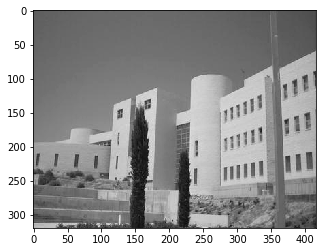

In [4]:
#img = readrgb('d2.jpg')[0:500,0:500]
img = readrgb('pano/pano001.jpg')

x = gray2float(rgb2gray(img))
imshowg(x)

In [5]:
gx,gy,gxx,gyy,gxy = grad2(gaussian(3,x))
h = gxx*gyy-gxy**2

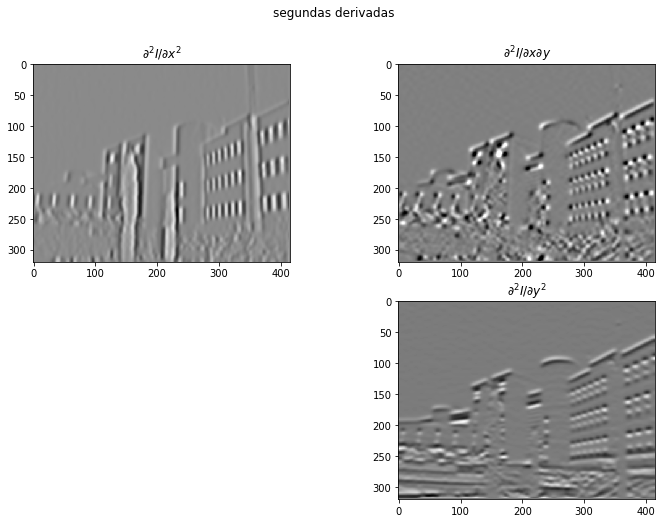

In [6]:
fig(12,8); plt.suptitle('segundas derivadas')
plt.subplot(2,2,1); imshowg(gxx); plt.title('$\\partial ^2 I/ \\partial x^2$')
plt.subplot(2,2,2); imshows(gxy); plt.title('$\\partial ^2 I/ \\partial x \\partial y$')
plt.subplot(2,2,4); imshowg(gyy); plt.title('$\\partial ^2 I/ \\partial y^2$');

El signo del determinante indica si la zona es una mancha compacta, más clara u oscura que su entorno, (positivo) o un punto de silla (negativo).

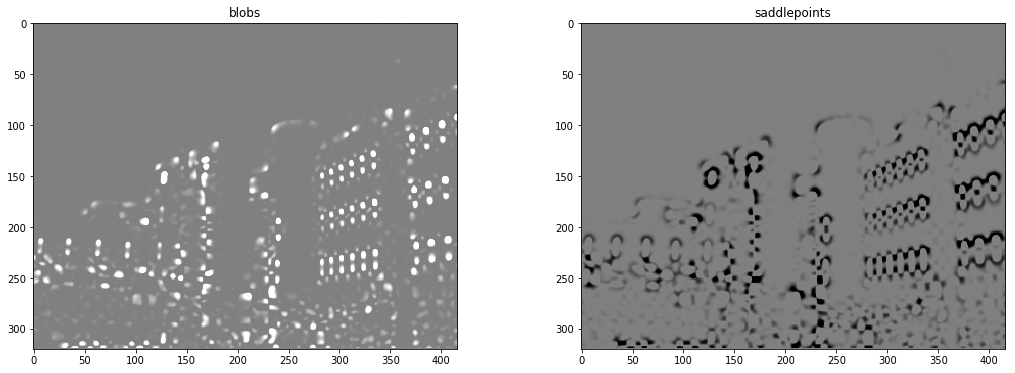

In [7]:
fig(18,6)
plt.subplot(1,2,1)
imshows(np.maximum(0,h),1); plt.title('blobs')
plt.subplot(1,2,2)
imshows(np.minimum(0,h),1); plt.title('saddlepoints');

Una forma rápida de encontrar los máximos del detector (*non maximum supression*) puede ser la siguiente:

In [8]:
def nms(x, t = 0.1):
    m = cv.dilate(x, np.ones((5,5),np.uint8))  # filtro de máximo
    h = np.max(m)
    return (x == m) & (x > t*h)

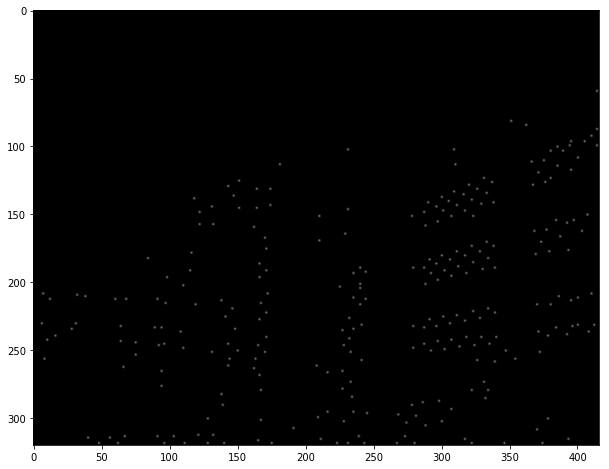

In [9]:
k = nms(-h)
fig(12,8)
#imshowg(k)
plt.imshow(k, 'gray', interpolation='bicubic');

Lo anterior es una imágen booleana. De ella extraemos las coordenadas de los puntos:

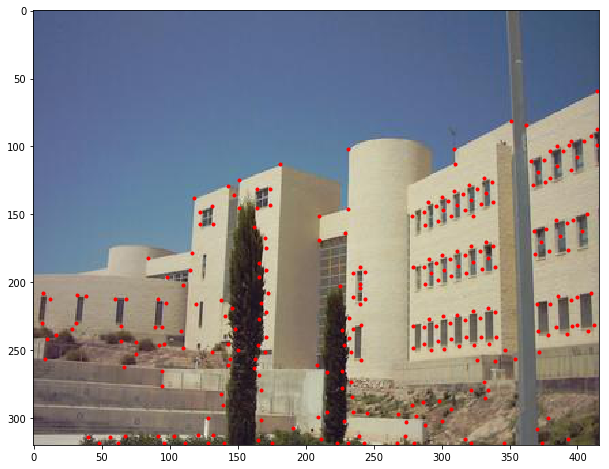

In [10]:
py,px = np.where(k)

fig(12,8)
plt.imshow(img); #ax = plt.axis();
plt.plot(px,py,'.r'); #plt.axis(ax);

Disgresión: los puntos de hessiano grande tienen la información relevante, son zonas no lineales y con ellas se puede reconstruir una versión aproximada de la imagen, de forma parecida a lo que hicimos con los bordes de Canny.

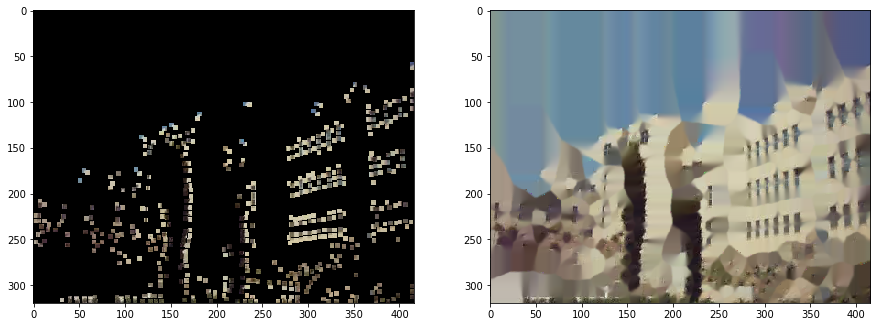

In [11]:
k = nms(abs(h),0.05)

mask = cv.dilate(k.astype(np.uint8), np.ones((5,5),np.uint8))
xx = img.copy()
xx[mask==0] = 0,0,0
dst = cv.inpaint(img,1-mask,3,cv.INPAINT_NS);

fig(15,6)
plt.subplot(1,2,1); plt.imshow(xx);
plt.subplot(1,2,2); plt.imshow(dst);

### Espacio de escala

La intensidad del detector depende de la escala de análisis:

In [12]:
from ipywidgets import interactive

xb = gray2float(rgb2gray(readrgb('disk1.jpg')))

def fun(s):
    gx,gy,gxx,gyy,gxy = grad2(gaussian(s,xb))
    h = gxx*gyy-gxy**2
    imshowf(h);

interactive(fun, s=(1,20))    

interactive(children=(IntSlider(value=10, description='s', max=20, min=1), Output()), _dom_classes=('widget-interact',))

Esto sugiere la posibilidad de detectar automáticamente la escala óptima de cada punto. La idea es construir una ["pirámide"][1] de imágenes cada vez más suavizadas, y encontrar los puntos de ese espacio 3D $(x,y,\sigma)$ que son máximos locales (los que tienen una respuesta mayor que sus 9 vecinos).

[1]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

En lugar de calcular el Hessiano es más eficiente calcular el Laplaciano,con un truco matemático que permite calcularlo como diferencia de dos niveles consecutivos de suavizado. Es el operador "DOG". 

Como ejemplo vamos a intentar detectar los círculos y su tamaño en la siguiente imagen:

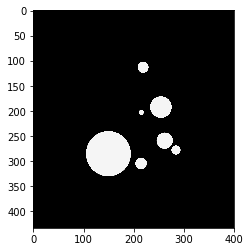

In [13]:
xc = cv.resize(readrgb('circles.jpg'),(0,0), fx=0.1, fy=0.1)

x = 1-np.pad(gray2float(rgb2gray(xc)),100,mode='constant',constant_values=1)
imshowg(x)

Creamos el espacio de escala. Para que el proceso sea más eficiente habría que ir reduciendo la imagen de tamaño, pero nosotros ahora no lo hacemos para poder comparar las etapas de forma directa.

In [14]:
pyr = np.array([gaussian(1.2**k,x) for k in range(0,20)])

In [15]:
def fun(k=15):
    plt.imshow(pyr[k],'gray',vmin=pyr.min(),vmax=pyr.max());

interactive(fun, k=(0,19))    

interactive(children=(IntSlider(value=15, description='k', max=19), Output()), _dom_classes=('widget-interact',))

Ahora calculamos las diferencias entre ellas:

In [16]:
dog = np.array([xa-x for x,xa in zip(pyr,pyr[1:])])
dog.max(), dog.min()

(2.0749921811627683, -0.61599761801938513)

In [17]:
def fun(k=14):
    plt.imshow(dog[k],'gray',vmin=dog.min(),vmax=dog.max());

interactive(fun, k=(0,18))    

interactive(children=(IntSlider(value=14, description='k', max=18), Output()), _dom_classes=('widget-interact',))

Los puntos interesantes son los extremos locales en este bloque 3D. Afortunadamente tenemos una función que nos permite programar el *nonmaximum supression* multidimensional de forma inmediata.

In [18]:
import scipy.ndimage

In [19]:
ks = scipy.ndimage.maximum_filter(dog,3)

In [20]:
S,R,C = np.where((ks==dog) & (dog > 0.3))
S,R,C

(array([ 6,  7,  7,  9, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18]),
 array([278, 114, 304, 259, 192, 263, 305, 309, 312, 318, 320, 260, 281,
        187, 283, 163, 164, 165, 167, 169, 176, 181, 182, 185, 285, 175,
        177, 179, 227, 157, 171, 226, 158, 225, 249, 249, 252, 260, 262,
        265, 269, 273, 291, 297, 301, 305, 307, 310, 312, 314, 316, 319, 339]),
 array([284, 218, 214, 261, 254, 281, 231, 230, 229, 223, 218, 283, 266,
        227, 263, 261, 264, 267, 270, 273, 279, 226, 282, 283, 150, 283,
        284, 285, 255, 233, 286, 274, 224, 285,  99, 209,  97,  93,  92,
         91,  90,  89,  88,  89,  90,  91,  92,  93,  94,  95,  96,  98, 180]))

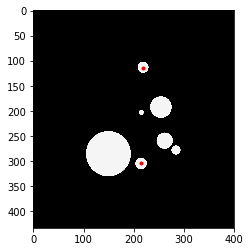

In [21]:
sc = 7
imshowg(x);
plt.plot(C[S==sc],R[S==sc],'.r');

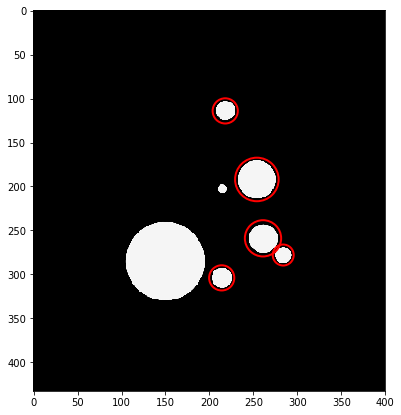

In [22]:
fig(7,7)

imshowg(x)

ax = plt.gca()

for s,r,c in zip(S,R,C):
    if 1 <= s <= 10 and dog[s,r,c]>0.3:
        #print(dog[s,r,c])
        ax.add_patch(plt.Circle((c,r), 4*1.2**s,color='red',fill=False,lw=2));

Algunos puntos detectados con DoG son bordes. Hay que eliminarlos calculando el Hessiano (solamente en ellos, no en las imágenes completas a todas las escalas).

Comparemos con los verdaderos extremos del Hessiano en el espacio de escala.

In [23]:
def hess(x):
    _,_,gxx,gyy,gxy = grad2(x)
    h = gxx*gyy-gxy**2
    return h

En este caso los suavizados de la pirámide se normalizan con $\sigma^2$ para poder comparar los hessianos a diferentes escalas. ([Verificar](https://www.nature.com/articles/s41598-018-19379-x))

In [24]:
pyr2 = np.array([1.2**k*gaussian(1.2**k,x) for k in range(0,25)])

hs = np.array([hess(x) for x in pyr2])

In [25]:
def fun(k=15):
    plt.imshow(hs[k],'coolwarm',vmin=-hs.max()/2,vmax=hs.max()/2);

interactive(fun, k=(0,24))

interactive(children=(IntSlider(value=15, description='k', max=24), Output()), _dom_classes=('widget-interact',))

Mostramos los extremos más intensos:

[ 7  9  9 10 11 11 12 12 13 13 15 19] [203 263 281 279 114 304 282 318 259 321 192 285] [214 284 269 285 218 214 206 196 260 196 254 149]


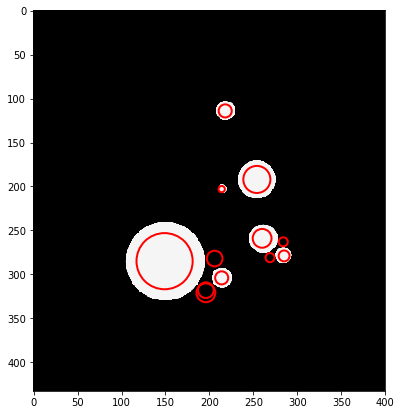

In [26]:
ks = scipy.ndimage.maximum_filter(hs,3)

S,R,C = np.where((ks==hs) & (hs >50))
print(S,R,C)

fig(7,7)
imshowg(x)
ax = plt.gca()
for s,r,c in zip(S,R,C):
    #if 19 <= s <= 19: # and (hs[s][r,c]) > 0:
        #print(dog[s,r,c])
        ax.add_patch(plt.Circle((c,r), 1.2**s,color='red',fill=False,lw=2));

(Pendiente: relacionar las escalas de DoG y de H.)

## SIFT: *scale invariant feature transform*

Es uno de los [métodos más conocidos](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) para extraer puntos de interés. Obtiene puntos característicos con una escala y orientación, y con un *descriptor* de apariencia que permite calcular coincidencias entre puntos de diferentes imágenes. Esto permite resolver muchos problemas de visión artificial, tanto de reconocimiento de objetos como de geometría visual. La detección se basa en máximos locales del determinante Hessiano en el espacio de escala aprovechando el método DoG anterior, y el descriptor es un histograma de gradientes orientados HOG muy parecido al que ya hemos estudiado, tomado en una región de imagen del tamaño indicado por la escala del punto y rotado en la dirección dominante.

OpenCV proporciona un implementación de SIFT. Para calcular a la vez los puntos y los descriptores usamos `detectAndCompute`. Los puntos son estructuras con los campos que se muestran en el siguiente trozo de código, y los descriptores se devuelven como filas de un array. El número de puntos y su intensidad se controla con los argumentos de [SIFT_create](https://docs.opencv.org/3.4/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html).

In [27]:
sift = cv.xfeatures2d.SIFT_create(nfeatures=0, contrastThreshold = 0.04)

kp,desc = sift.detectAndCompute(img, mask=None)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]
sc = [ p.size  for p in kp]
rs = [ p.angle for p in kp]

print(len(kp))
print(desc.shape)

619
(619, 128)


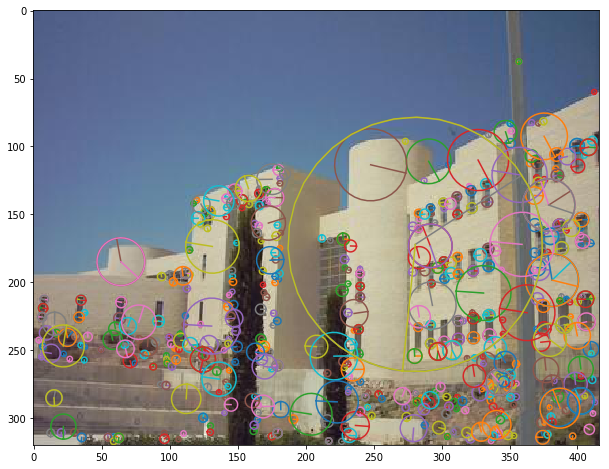

In [28]:
# para mostrar un keypoint en matplotlib, con su tamaño y orientación
def shkeypoint(k):
    t = np.linspace(k.angle,360+k.angle,36)*np.pi/180
    xs = k.pt[0]+k.size*np.cos(t)
    ys = k.pt[1]+k.size*np.sin(t)
    plt.plot(np.append(k.pt[0],xs),np.append(k.pt[1],ys))

fig(12,8)
plt.imshow(img); ax = plt.axis();
for k in kp:
    if k.size > 0:
        shkeypoint(k)
plt.axis(ax);

Veamos los puntos SIFT de la imagen de círculos anterior. Esta vez usamos la utilidad que proporciona OpenCV para dibujar los puntos.

30


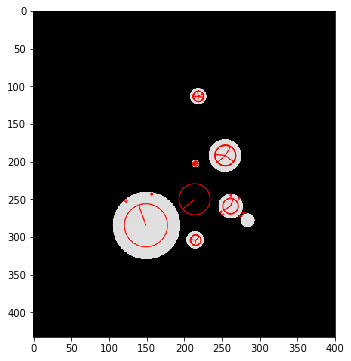

In [29]:
circ = rgb2gray(cv.resize(readrgb('circles.jpg'),(0,0), fx=0.1, fy=0.1))
circ = 255-cv.cvtColor(np.pad(circ,100,mode='constant',constant_values=255), cv.COLOR_GRAY2BGR)

kp, desc = sift.detectAndCompute(circ, mask=None)
flag = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv.drawKeypoints(circ,kp,circ, color=(255,0,0), flags=flag)

fig(6,6)
print(len(kp))
plt.imshow(circ,'gray');

### Image matching using keypoints

Una aplicación directa es el reconocimiento de objetos: la similitud de dos imágenes se puede medir con el número de keypoints coincidentes (que tienen descriptores muy parecidos).

La carpeta sift/models contiene buenas imágenes de tres cuadros de Vermeer. En la carpeta sift/tests hay fragmentos de esas obras tomadas de cualquier manera con la webcam.

In [30]:
import glob
def readfiles(path):
    return [readrgb(file) for file in sorted(glob.glob('../images/'+path))]

imgs = readfiles('sift/tests/*.*')
mods = readfiles('sift/models/*.*')

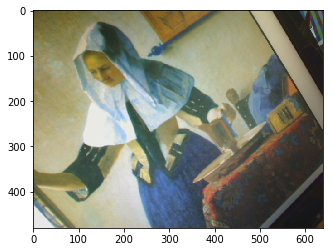

In [31]:
plt.imshow(imgs[1]);

Calculamos los puntos SIFT de todas las imágenes:

In [32]:
sift = cv.xfeatures2d.SIFT_create()

dis = [sift.detectAndCompute(x,None) for x in imgs]
dms = [sift.detectAndCompute(x,None) for x in mods]

Las coincidencias de keypoints entre dos imágenes se calculan con un ["matcher"](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html) y luego se filtran para dejar solo las que que no tengan ambigüedad. Una forma de hacer esto es el *ratio test*: se descartan los puntos cuya mejor coincidencia es parecida a la segunda mejor. Para conseguir esta información usamos el método *knn* (k-*nearest neigbors*) del *matcher*.

In [33]:
# por fuerza bruta
bf = cv.BFMatcher()


# fast approximate nearest neighbor
# pip install opencv-contrib-python

#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks=50)   # or pass empty dictionary
#flann = cv.FlannBasedMatcher(index_params,search_params)

modelo: 38266,  imagen: 415
coincidencias: 3 (0.7%)


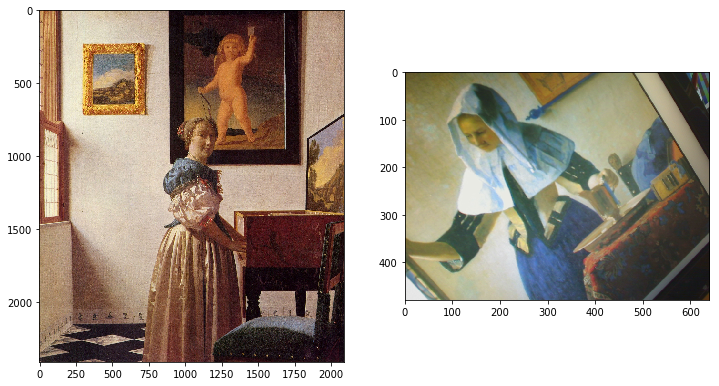

In [34]:
m = 2  # model
t = 1  # target

print('modelo: {},  imagen: {}'.format(len(dms[m][1]), len(dis[t][1])))

fig(12,8)
plt.subplot(1,2,1); plt.imshow(mods[m]);
plt.subplot(1,2,2); plt.imshow(imgs[t]);

#                     query      model    num de vecinos
matches = bf.knnMatch(dis[t][1],dms[m][1],k=2)
#matches = flann.knnMatch(dis[t][1],dms[m][1],k=2)    

# ratio test
good = []
for mt in matches:
    if len(mt) == 2:
        best, second = mt
        if best.distance < 0.75*second.distance:
            good.append(best)        
        
        
print('coincidencias: {} ({:.1f}%)'.format(len(good),100*len(good)/len(dis[t][1])))

Cambiando el modelo `m` y la imagen de prueba `t` podemos comprobar que el número de puntos coincidentes o su proporción puede servir para reconocer objetos con suficiente textura. 

Los *matchings* contienen el grado de coincidencia y los índices de los puntos de interés de la imagen desconocida y del modelo.

In [35]:
matching = good[0]

matching.distance

137.4299774169922

In [36]:
matching.queryIdx

2

In [37]:
matching.trainIdx

36237

La función `cv.drawMatches` representa gráficamente las posiciones de los puntos coincidentes.

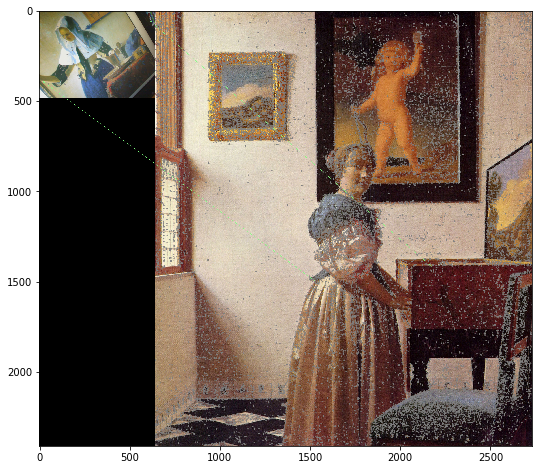

In [38]:
fig(12,8)
plt.imshow(cv.drawMatches(imgs[t], dis[t][0], mods[m], dms[m][0], good,
                      flags=0,
                      matchColor=(128,255,128),
                      singlePointColor = (128,128,128),
                      outImg=None) );

### Otros *Keypoints* disponibles en OpenCV

OpenCV tiene muchos otros detectores de *keypoints*, que suelen utilizarse con un interfaz común.

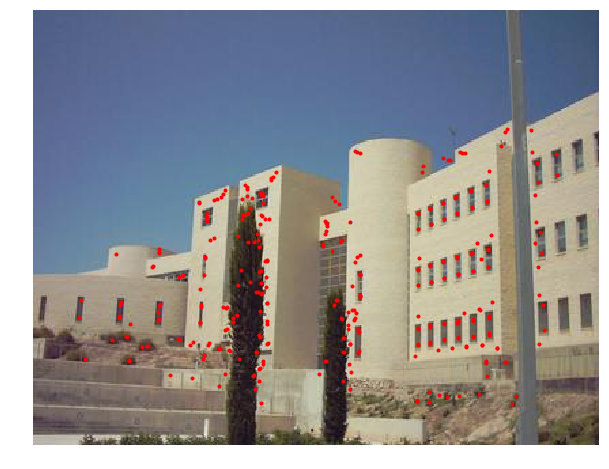

In [39]:
#method = cv.xfeatures2d.StarDetector_create()
#method = cv.FastFeatureDetector_create()
#method = cv.ORB_create()
#method = cv.xfeatures2d.SIFT_create()
#method = cv.xfeatures2d.SURF_create()
method = cv.AKAZE_create()

kp = method.detect(img)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]

fig(12,8)
plt.imshow(img); ax = plt.axis('off');
plt.plot(xs,ys,'.r'); plt.axis(ax);

Dependiendo de las necesidades de nuestra aplicación (velocidad de cálculo vs estabilidad de los puntos) elegiremos el más adecuado.

## *Bag of visual words*

Cuando hay muchos modelos la búsqueda de coincidencias en todos ellos puede ser muy costosa. Una forma de acelerar el proceso es construir un "[vocabulario visual](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)" a partir de una gran colección de keypoints extraídos de los modelos disponibles o de escenas parecidas (mediante [k-means](https://en.wikipedia.org/wiki/K-means_clustering) o algún método parecido). Cada imagen se representa mediante un histograma que contabiliza el número de ocurrencias de cada "visual word". Este histograma sirve como *feature* para comparar las imágenes o para entrenar un clasificador. ([Csurka 2004](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/csurka-eccv-04.pdf)).